In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn import metrics
from scipy import stats


#Importing libraries for model creation
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

#Importing pre-processing
from sklearn import preprocessing
#Decomposition
from sklearn.decomposition import PCA
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


## Problem Approach

In this notebook we're tasked with clustering an unlabeled dataset with the evaluation metric being the RandScore. For our model we compare a Gaussian Mixture with a Bayesian Gaussian mixture and end up setting on the Bayesian Gaussian for the final submission. The overall approach is as follows:

* Data Loading
* Data Normalization
* Feature Selection
* Determining Optimal Number of Clusters
* Training Gaussian Mix model and Bayesian Gaussian Mix and compare results
* Submitting result from best model

## Loading Data

In [2]:
df = pd.read_csv('../input/tabular-playground-series-jul-2022/data.csv', index_col=False)
df = df.fillna(0)


## Data Scaling

A Gaussian Mixture model assumes that each variable follows a gaussian distribution. Examining the dataset below we can see this isnt the case with many variables being skewed. In order to correct this I used the  sklearn power transformer implementing the yeo-johnson method, this method doesnt require all datapoints to be positive (like a Box-Cox transform) and resulted in a better score than other transformerms.

In [3]:
#Shaping to appropriate format
df_copy = df.drop(columns = ['id'])

scaler = preprocessing.PowerTransformer(method = 'yeo-johnson', standardize=True).fit(df_copy.values)
scaled_df = pd.DataFrame(scaler.transform(df_copy.values), index = df_copy.index, columns = df_copy.columns)
p_vals = []
for col in df_copy.columns:
    pre_transform = stats.shapiro(df[col]).pvalue
    post_transform = stats.shapiro(scaled_df[col]).pvalue
    p_vals.append([col, pre_transform, post_transform])

p_val_df = pd.DataFrame(p_vals, columns = ['Variable', 'Pre-Transform', 'Post-Transform'])
print(p_val_df.sort_values(by=['Pre-Transform']))


melted_df_pre = df_copy.melt(value_vars = df_copy.columns,
                    value_name = 'Value', var_name = 'Variable')
melted_df_post = scaled_df.melt(value_vars = df_copy.columns,
                    value_name = 'Value', var_name = 'Variable')
melted_df_pre['Transform'] = 'No Transform'
melted_df_post['Transform'] = 'yeo-johnson'
melted_df = pd.concat([melted_df_pre, melted_df_post], ignore_index = True)


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


   Variable  Pre-Transform  Post-Transform
9      f_09   0.000000e+00    0.000000e+00
13     f_13   0.000000e+00    0.000000e+00
12     f_12   0.000000e+00    0.000000e+00
11     f_11   0.000000e+00    0.000000e+00
10     f_10   0.000000e+00    0.000000e+00
7      f_07   0.000000e+00    0.000000e+00
8      f_08   0.000000e+00    0.000000e+00
27     f_27   1.863585e-36    4.036984e-34
26     f_26   4.429073e-36    5.159281e-36
28     f_28   2.838907e-20    2.727299e-08
25     f_25   9.014025e-17    4.695765e-08
22     f_22   5.754255e-16    5.744988e-13
23     f_23   6.267771e-13    5.981866e-13
24     f_24   9.434243e-08    1.500942e-07
20     f_20   1.050585e-01    1.516246e-01
6      f_06   3.011470e-01    5.044012e-01
4      f_04   4.264995e-01    7.434608e-01
21     f_21   4.309510e-01    5.788363e-01
3      f_03   5.071116e-01    8.379760e-01
14     f_14   5.629967e-01    9.685720e-01
16     f_16   6.558671e-01    6.558444e-01
15     f_15   7.478742e-01    6.571526e-01
2      f_02

<bound method Grid.tight_layout of <seaborn.axisgrid.FacetGrid object at 0x7f175ae90150>>

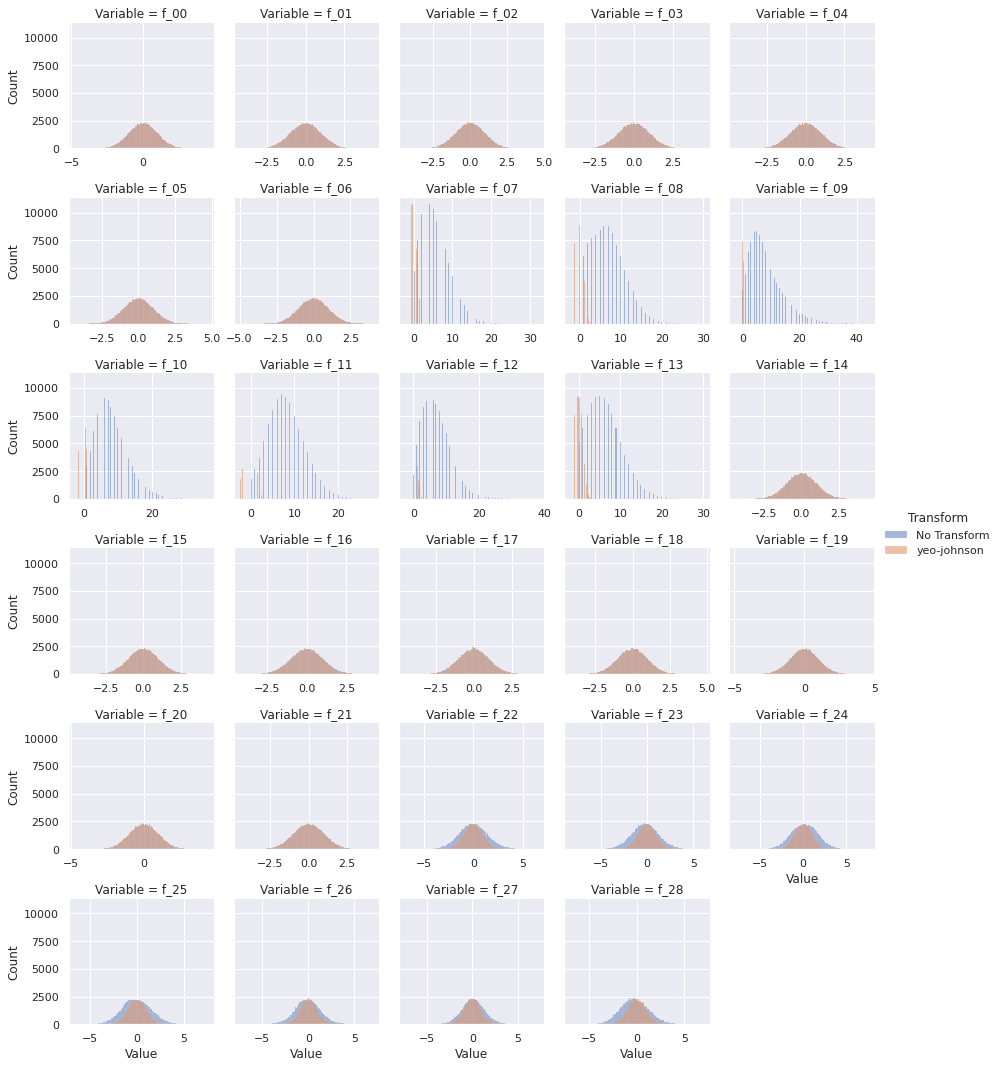

In [4]:
#melted_df.head(n = 10)
sns.set(rc = {'figure.figsize':(15,12)})
v = sns.FacetGrid(melted_df, col='Variable', hue = 'Transform', height=2.5, col_wrap=5, sharex = False)
v.map(sns.histplot, 'Value', alpha = 0.5).add_legend()
v.tight_layout

## Filtering for Best Variables

Basing the approach off the notebook here: https://www.kaggle.com/code/ricopue/tps-jul22-clusters-and-lgb

we're going to take a subset of our factors to use for model training.




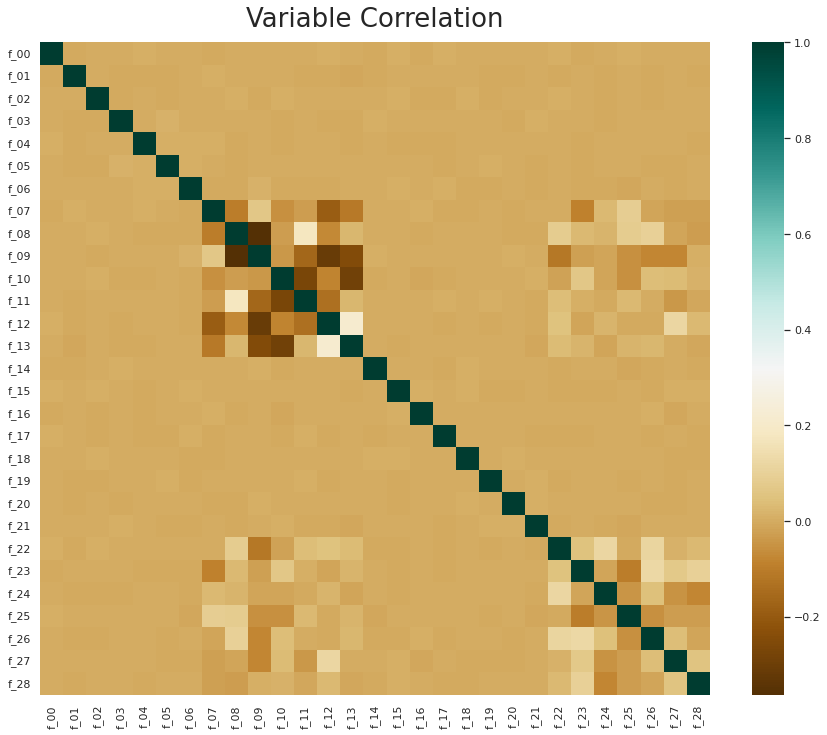

In [5]:
sns.set(rc = {'figure.figsize':(15,12)})
sns.set_style('white')
heatmap = sns.heatmap(scaled_df.corr(), annot=False, cmap='BrBG',)
heatmap.set_title('Variable Correlation', fontdict={'fontsize':26}, pad=16);


In [6]:
best_data =['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']
scaled_df = scaled_df[best_data]

## Parameter Tuning

The first parameter we need to identify is the number of clusters to predict. We'll do this by taking a subset of the data(to reduce training time) and training a model for between 2-15 clusters. 

To compare model performance we'll use the Silhouette score explained here: https://en.wikipedia.org/wiki/Silhouette_(clustering). 

Given that increasing the number of groups will naturally lead to a lower silhouette score we'll use the elbow method explained here: https://en.wikipedia.org/wiki/Elbow_method_(clustering) to look at when the rate of change reduces as we increase the number of clusters.

The best leaderboard score was a result of using n = 7 clusters

Number of Clusters:  2  Score:  0.05977763185428336
Number of Clusters:  3  Score:  0.05482446220731411
Number of Clusters:  4  Score:  0.05825915477833355
Number of Clusters:  5  Score:  0.04469490247962724
Number of Clusters:  6  Score:  0.03821952767484701
Number of Clusters:  7  Score:  0.03513966656921407
Number of Clusters:  8  Score:  0.029073205778613845
Number of Clusters:  9  Score:  0.026964790416566076
Number of Clusters:  10  Score:  0.027294138450073398
Number of Clusters:  11  Score:  0.02448890235909681
Number of Clusters:  12  Score:  0.015033216678652138
Number of Clusters:  13  Score:  0.025665202323129268
Number of Clusters:  14  Score:  0.01666843113705842


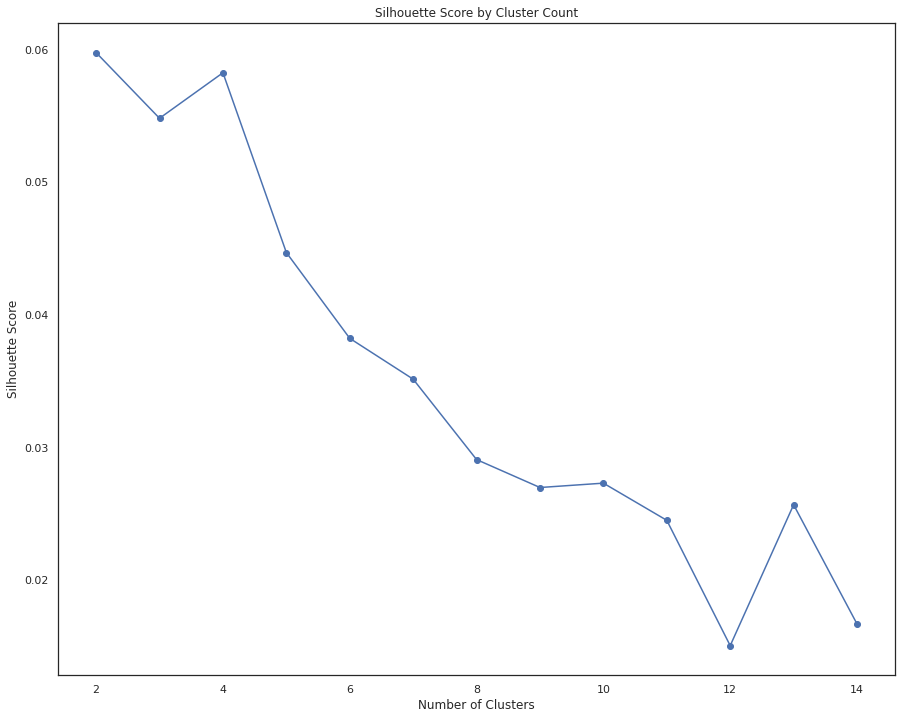

In [7]:
sample_df = scaled_df.sample(n = 5000)
clusters = range(2,15)
scores = []

for i in clusters:
    gm = GaussianMixture(n_components=i, n_init=5, init_params='kmeans',
                        verbose = 0)
    gm_prediction = gm.fit_predict(sample_df)
    # Calculate Silhoutte Score and append to a list
    score = metrics.silhouette_score(sample_df, gm_prediction, metric='euclidean')
    scores.append(score)
    print('Number of Clusters: ', i, ' Score: ', score)
  

plt.plot(clusters, scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Cluster Count')
plt.show()

## Training Full Models
Using the identified number of clustes we'll train a model a bayesian gaussian mixture model and a gaussian mixture model on the full, scaled dataset, and compare the silhouette score of the two approaches

In [8]:
b_gm = BayesianGaussianMixture(n_components=7, n_init=5, verbose = 0.5,tol = 0.0001, max_iter = 200).fit(scaled_df)
gm = BayesianGaussianMixture(n_components=7, n_init=5, verbose = 0.5,tol = 0.0001, max_iter = 200).fit(scaled_df)
gm_prediction = gm.predict(scaled_df)
b_gm_prediction = b_gm.predict(scaled_df)
score_b_gm = metrics.silhouette_score(scaled_df, b_gm_prediction, metric='euclidean')
score_gm = metrics.silhouette_score(scaled_df, gm_prediction, metric='euclidean')
print(score_b_gm)
print(score_gm)

0.03555118751474343
0.0355519299224047


## Visualizing Results

Using principle component analysis we can reduce our dataset to 2 dimensions and visualize the clustering below. Unfortunately we cant capture all the variance of the dataset in two dimensions as shown by plotting the explained variance of each principle component so our 2d clustering visualization isnt perfect.

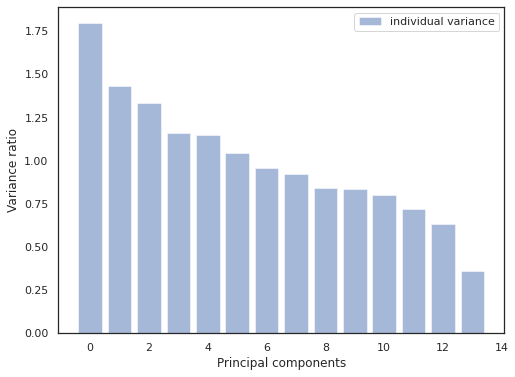

[Text(0.5, 1.0, 'Clustering Group Visualization with PCA')]

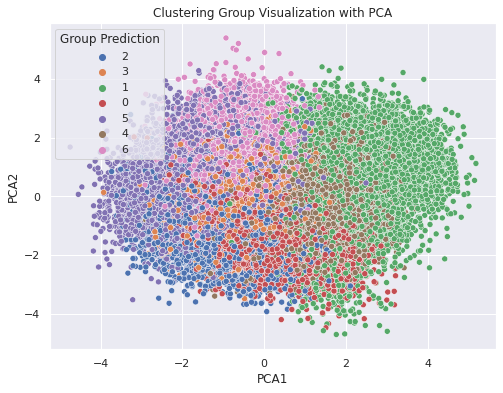

In [9]:
gm_prediction = gm.predict(scaled_df)
pca = PCA()
pca.fit_transform(scaled_df)
pca2 = PCA(n_components=2)
pca2.fit(scaled_df)

#Visualizing variance explanation of each principle component
variance = pca.explained_variance_
plt.figure(figsize=(8, 6))
plt.bar(range(len(variance)), variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

#Visualizing clustering
sns.set(rc = {'figure.figsize':(8,6)})
scaled_pca = pd.DataFrame(pca2.transform(scaled_df), columns = ['PCA1', 'PCA2'])
scaled_pca['Group Prediction'] = gm_prediction.astype(str)
sns.scatterplot(data = scaled_pca, x = 'PCA1', y = 'PCA2', hue = 'Group Prediction').set(title = 'Clustering Group Visualization with PCA')


## Making Prediction and Writing to File

In [10]:
b_gm_prediction = b_gm.predict(scaled_df)
labels = df['id']
b_gm_submission = pd.DataFrame(np.array([labels, b_gm_prediction]).T,
                                 columns = ['Id', 'Predicted'])
b_gm_submission.to_csv('b_gm_output2.csv', index=False)
